# Text classification

<a href="https://colab.research.google.com/github/antoniotrapote/text-mining/blob/main/05_TextClassification_FeaturesAndLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![View on GitHub](https://img.shields.io/badge/View_on-GitHub-black?logo=github)](https://github.com/antoniotrapote/text-mining/blob/main/05_TextClassification_FeaturesAndLM.ipynb)

In [ ]:
!wget https://github.com/antoniotrapote/text-mining/raw/main/datasets/datos_twitter_master.tsv
import sys
!{sys.executable} -m pip install contractions
!pip install spacy
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!pip install datasets
!pip install evaluate
!pip install numpy==1.26


# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import contractions
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

/tmp/ipython-input-1-379499608.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Cargar y preparar los datos


En primer lugar, descargaremos el conjunto de datos anotados. En este caso trabajaremos con documentos provenientes de la red social Twitter.

In [2]:
dataset = pd.read_csv('datos_twitter_master.tsv', sep = "\t") # 'datos_twitter_master.tsv', sep = "\t"

# Análisis exploratorio de los datos (EDA)




En este apartado pretendemos realizar un análisis de los datos previo a la normalización de los mismos. Este análisis nos va a permitir extraer información relevante del dataset, así como posibles inconvenientes que serán solucionados llegado el caso.


* **Número de documentos y columnas:**

Comenzamos mostrando el número de documentos, o lo que es lo mismo, el número de filas del data frame:

In [3]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))  # len(dataset)
print("El dataframe tiene {} columnas".format(dataset.shape[1]))  # dataset.shape[1]

Tenemos un conjunto de 1020 documentos
El dataframe tiene 2 columnas


* **Número de documentos duplicados:**

Despues, comprobamos y eliminamos las filas con algún valor vacío (NA) y quitaremos los duplicados.

In [4]:
print("Existen {} documentos duplicadas".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))  # dataset.duplicated(subset=["tweet_text"])

Existen 1 documentos duplicadas


In [5]:
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} documentos".format(dataset.shape[0]))

Despues de quitar duplicados tenemos un conjunto de 1019 documentos


Comprobaramos que no hayan quedado Nulls en ningunas de las dos columnas del dataset

In [7]:
null_counts = dataset.isnull().sum()
print("Hay {} valores vacíos en los tweets y {} valores vacíos en las etiquetas en los datos".format(null_counts.iloc[0], null_counts.iloc[1] ))


Hay 0 valores vacíos en los tweets y 0 valores vacíos en las etiquetas en los datos


Si hubiera habido algún valor vacío o null en la columna de etiquetas, habría que revisar si este error estaba relacionado con un error del documento original o por un problema en la lectura de los datos.  

* **Número de documentos por cada clase:**

Contamos el número de elementos de cada clase, esto se hace fácilmente con un `groupby()` sobre la columna 'molestia' y un conteo de elementos posteriormente. También se podría utilizar el método `value_counts()` sobre la serie asociada a la categoría asociada a los documentos.

En este caso nos encontramos dos categorías para los documentos (tweets):

- "Molestia = 1": Tweets con la palabra ruido que hacen referencia a molestias sufridas por ruido acústico proveniente de distintas fuentes (coches, vecinos, mascotas,...)
- "Molestia = 0": Tweets que contienen la palabra ruido perso no expresan una molestia sufrida por el usuario que lo escribió (otras acpciones de ruido, noticias que hablan sobre ruido o uso de ruido como algo positivo)

In [9]:
print(dataset["molestia"].value_counts())

molestia
1    510
0    509
Name: count, dtype: int64


In [10]:
# Número de elementos de cada clase:
dataset.groupby(['molestia']).count()

,tweet_text
molestia,
0,509
1,510


Viendo los resultados podemos observar que el conjunto de datos tiene las categorías balanceadas. Esto nos evitará problemas en el entrenamiento de los modelos más adelante.

Específicamente contamos con 509 documentos con la categoría '0' y 510 documentos con la categoría '1'.



Vamos a dibujar un histograma con las clases para practicar la visualización y comunicación de resultados:

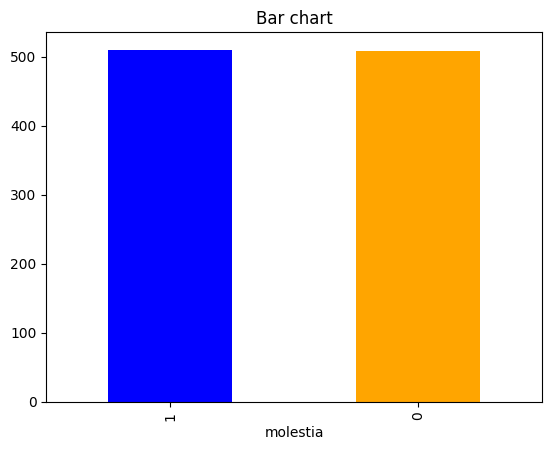

In [11]:
ax, fig = plt.subplots()
etiquetas = dataset.molestia.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Llevar a cabo un análisis exploratorio de los documentos es un proceso más complejo que el análisis llevado a cabo en datos numéricos debido a que la naturaleza no numérica del texto implica dificultades para el cálculo de estadísticos típicos como la media o desviación típica.  En este ejercicio planteamos algunos métodos básicos para llevar a cabo este análisis exploratorio:


* **Distribución de la longitud de los tweet en caracteres:**

Para seguir con el análisis exploratorio, vamos a hacer un cálculo la longitud de cada uno de los textos de los documentos para posteriormente dibujar su histograma y ver diferencias entre las categorías del dataset:

In [14]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x)) # lambda y len

In [15]:
dataset.head()

,tweet_text,molestia,char_len
0,Noise harassment is a sensation pain based tor...,1,50
1,It's 4.30am and we still haven't slept because...,1,106
2,These birds acting like I can't grab my chains...,1,143
3,Why do people leave the annoying tap-tap keybo...,1,136
4,Please would you keep the noise down? We're re...,1,109


<Figure size 1400x1200 with 0 Axes>

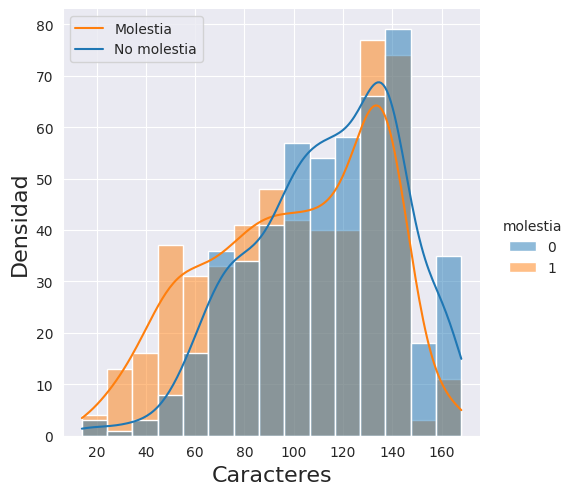

In [17]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="molestia", kde=True, legend=True) # dataset
plt.legend(["Molestia", "No molestia"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

En el caso de Twitter la mayoría de documentos tienen una longitud muy reducida (menos de 200 caracteres). Comparando las longitudes de los documentos asociados a cada categoría, se aprecia que los tweets que expresan 'molestia' tienen una longitud algo menor.

* **Análisis de contenido de los tweets**

Para llevar a cabo un análisis del contenido de los tweets se podrían optar por diferentes técnicas. Desde el cálculo de términos más frecuentes en cada una de las categorías, a técnicas más complejas como el *Topic Modeling* (técnica que veremos más adelante en el módulo.  

En este caso utilizaremos una visualización conocida como **word cloud**, en la que se representa visualmente los términos más frecuentes de un conjunto de textos, pero dando más hincapié a los términos más frecuentes en la visualización.

Para llevar a cabo esta visualización utilizaremos un recurso de sencilla utilización y personalización, la librería [wordcloud](https://amueller.github.io/word_cloud/)

Importamos el objeto WordCloud

In [18]:
from wordcloud import WordCloud

Para generar los gráficos necesitamos obtener una variable de tipo `string` que contenga todos los textos con los que queremos llevar a cabo la visualización. En este caso obtendremos separadamente los tweets asociados a la categoría 0 y a la categoría 1.

In [20]:
txt_cat0 = ",".join(dataset[dataset.molestia==0].tweet_text.to_list()) # Nos quedamos con dataset.molestia==0
txt_cat1 = ",".join(dataset[dataset.molestia==1].tweet_text.to_list()) # Nos quedamos con dataset.molestia==1

Una vez obtenidos la variable de texto, crearemos un objeto `WordCloud` con la configuración que nos permita obtener las visualizaciones

In [21]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english') # 'english'

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

Una vez generado el objeto ya podemos utilizarlo para llevar a cabo la generación y visualización del resultado

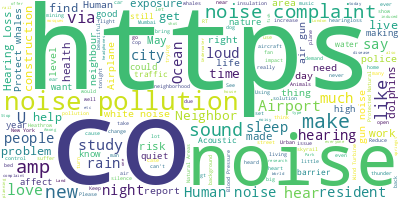

In [22]:
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

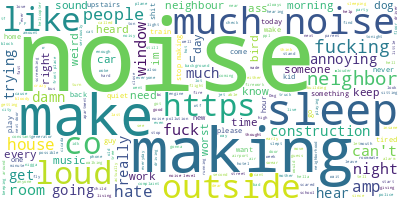

In [23]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

Observando los resultados, vemos los siguientes fenómenos:
  - En el wordcloud de la categoría 0 se observa que hay una alta presencia de URLs (presencia de *https* y *co*), así como de la palabra *noise*. Son términos que no muestran opiniones a excepción de algunos adjetivos como *quiet* o *loud*.
  - En el wordcloud asociado a la categoría 1 se observa una menor frecuencia del término *https* (es decir que habrá menos URLs en el contenido). Aparecen adjetivos que expresan opinión y molestias como *fucking*, *make noise*, o *hate*.

En general, se obserban similitudes en los témrinos más presentes en ambos grupos (noise, https), pero varias diferencias en el resto del contenido.

Este tipo de visualización nos permite obtener ideas para modelar el problema posteriormente, incorporando características adicionales a las textuaels como el número de adjetivos, el número de URLs, o el sentimiento, como haremos en otro ejercicio.

# Entrenamiento con Ingeniería de características:


## Transformación
Como hemos visto, está dividido en dos pasos Normalización o Preprocesado y Transformación



### Normalización
Vamos a proceder a normalizar los datos. Para ello vamos a generar pequeñas funciones que nos permitan:
- Eliminar espacios extra entre términos.
- Transformar a minúsculas.
- Reemplazar contracciones del inglés.
- Normalizar URLs, menciones de twitter y números por tokens comunes.
- Lematizar tokens, eliminar stopwords y eliminar sígnos de puntuación.


Este procedimiento lo haremos combinando la librería Spacy y otras librerías


En primer lugar eliminaremos espacios extras del texto y transformaremos todos los caracteres a minúsculas:

In [24]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

In [25]:
# Espacios y minuscula
dataset["normalized"] = dataset["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: texto_to_lower(x))

  0%|          | 0/1019 [00:00<?, ?it/s]

  0%|          | 0/1019 [00:00<?, ?it/s]

In [26]:
dataset.head()

,tweet_text,molestia,char_len,normalized
0,Noise harassment is a sensation pain based tor...,1,50,noise harassment is a sensation pain based tor...
1,It's 4.30am and we still haven't slept because...,1,106,it's 4.30am and we still haven't slept because...
2,These birds acting like I can't grab my chains...,1,143,these birds acting like i can't grab my chains...
3,Why do people leave the annoying tap-tap keybo...,1,136,why do people leave the annoying tap-tap keybo...
4,Please would you keep the noise down? We're re...,1,109,please would you keep the noise down? we're re...


A continuación normalizamos las contracciones y slang existentes en inglés:

In [28]:
# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    return contractions.fix(text, slang=True)

In [29]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: replace_contraction(x))

  0%|          | 0/1019 [00:00<?, ?it/s]

In [30]:
dataset.head()

,tweet_text,molestia,char_len,normalized
0,Noise harassment is a sensation pain based tor...,1,50,noise harassment is a sensation pain based tor...
1,It's 4.30am and we still haven't slept because...,1,106,it is 4.30am and we still have not slept becau...
2,These birds acting like I can't grab my chains...,1,143,these birds acting like i cannot grab my chain...
3,Why do people leave the annoying tap-tap keybo...,1,136,why do people leave the annoying tap-tap keybo...
4,Please would you keep the noise down? We're re...,1,109,please would you keep the noise down? we are r...


Depués normalizamos URLs (tokens que comienzan por https:), menciones de twitter (tokens que comienzan por @) y números. Aunque existen formas muy eficientes si se buscan patrones en el texto con una librería como `regex`, vamos a optar por tokenizar el documento, y en función de las características del token sustiuiremos el token o lo dejaremos igual.

In [33]:
# Tokenizador
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento) # tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"): #startswith "@"
            palabras[i] = "MENTION"
        elif palabras[i].isdigit(): # .isdigit()
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

In [34]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: normalizar_tokens(x))

  0%|          | 0/1019 [00:00<?, ?it/s]

In [35]:
dataset.head()

,tweet_text,molestia,char_len,normalized
0,Noise harassment is a sensation pain based tor...,1,50,noise harassment is a sensation pain based tor...
1,It's 4.30am and we still haven't slept because...,1,106,it is 4.30 am and we still have not slept beca...
2,These birds acting like I can't grab my chains...,1,143,these birds acting like i cannot grab my chain...
3,Why do people leave the annoying tap-tap keybo...,1,136,why do people leave the annoying tap-tap keybo...
4,Please would you keep the noise down? We're re...,1,109,please would you keep the noise down ? we are ...


In [ ]:
dataset.normalized.to_list()

Por último llevamos a cabo la lematización y eliminación de puntuación y stopwords:

In [37]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return


In [39]:
dataset["preprocessed_text"] = dataset["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

  0%|          | 0/1019 [00:00<?, ?it/s]

Una vez procesado el texto, vamos a rehacer los word clouds para interpretar mejor el contenido de éste y visualizar el correcto funcionamiento del proceso:

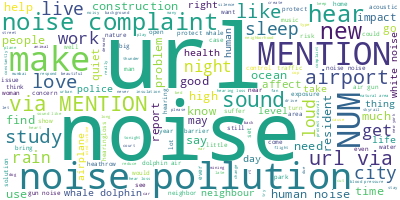

In [40]:
txt_cat0 = ",".join(dataset[dataset.molestia==0].preprocessed_text.to_list())
txt_cat1 = ",".join(dataset[dataset.molestia==1].preprocessed_text.to_list())
#
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

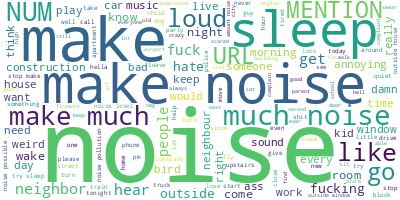

In [41]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

Una vez preprocesado, podríamos calcular alguna característica adicional, como el número de URLs o menciones:

In [42]:
def token_appearance(document, token = "MENTION"):
  return len([x for x in document.split() if x == token])

In [43]:
dataset["num_mention"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="MENTION"))
dataset["num_URLS"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="URL"))
dataset["num_NUM"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="NUM"))

  0%|          | 0/1019 [00:00<?, ?it/s]

  0%|          | 0/1019 [00:00<?, ?it/s]

  0%|          | 0/1019 [00:00<?, ?it/s]

In [44]:
def count_adj(texto):
  doc = nlp(texto)
  return len([token for token in doc if token.pos_ == "ADJ"])

In [45]:
dataset['num_ADJ'] = dataset['preprocessed_text'].apply(lambda x: count_adj(x))

In [46]:
dataset.head()

,tweet_text,molestia,char_len,normalized,preprocessed_text,num_mention,num_URLS,num_NUM,num_ADJ
0,Noise harassment is a sensation pain based tor...,1,50,noise harassment is a sensation pain based tor...,noise harassment sensation pain base torture,0,0,0,0
1,It's 4.30am and we still haven't slept because...,1,106,it is 4.30 am and we still have not slept beca...,still sleep noise think ever city person haha,0,0,0,0
2,These birds acting like I can't grab my chains...,1,143,these birds acting like i cannot grab my chain...,bird act like grab chainsaw fall damn tree mak...,0,0,1,1
3,Why do people leave the annoying tap-tap keybo...,1,136,why do people leave the annoying tap-tap keybo...,people leave annoying tap tap keyboard noise p...,0,0,0,2
4,Please would you keep the noise down? We're re...,1,109,please would you keep the noise down ? we are ...,please would keep noise rehearse dartington ME...,1,1,0,1


### Vectorizacion del texto


Queremos que la funcionalidad 'TfidfVectorizer' tenga en cuenta los siguientes aspectos:

- Limitar el tamaño de características del vector que representa el documento
- Considerar unigramas, bigramas y trigramas
- Que el sistema no considere los elementos que salgan en menos del 0.5% de los documentos.

In [47]:
vectorizador = TfidfVectorizer(
    lowercase=False,
    stop_words=None,
    ngram_range=(1,3),
    min_df=0.005
    )

In [48]:
vector_data = vectorizador.fit_transform(dataset['preprocessed_text']) # "preprocessed_text"

El resultado del proceso de vectorización nos devuelve vectores de tamaño 375:

In [49]:
vector_data

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7188 stored elements and shape (1019, 372)>

#### Incorporación de características adicionales

Previamente hemos calculado algunas características adicionales que podrían ayudar al clasificador a tener mejor rendimiento. Vamos a incorporarlas a la representación vectorial de los documentos.


La forma más sencilla de hacer esto es utilizar la librería *scipy* y generar una matriz sparse, comprensible por scikit-learn, que contenga tanto las características de TFIDF como las calculadas manualmente.

En primer lugar, debemos seleccionar el conjunto de variables que queremos considerar en el entrenamiento. PAra ello hacemos uso del selector `dataframe[["nombre_columna1", "nombre_columna2"]]`:



In [51]:
extra_features = dataset[['num_mention','num_URLS','num_NUM', 'num_ADJ']] #'num_mention','num_URLS','num_NUM'

In [52]:
vector_data.dtype

dtype('float64')

Utilizamos la librería scipy (función sparse.hstack) para unir las características TFIDF (contenidas en ´vector_data´) con las que acabamos de seleccionar (´extra_features´). Esta unión nos generará una matriz X que utilizaremos para hacer el train-test split posteriormente:

In [53]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = dataset["molestia"].values.astype(np.float32)
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

También vamos a extraer el nombre de las caracteríticas por si quisieramos utilizarlos con posterioridad.

In [54]:
X_columns=list(vectorizador.get_feature_names_out())+extra_features.columns.tolist()

## Entrenar/validar el clasificador:

Entramos ya en el apartado de entrenamiento del modelo.

Contamos con un conjunto de características predictoras extraídas del texto (variable X), y las categorías asignadas manualmente en el conjunto de datos (y).

In [55]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8229 stored elements and shape (1019, 376)>

Tenemos 378 características para 1019 documentos.

En primer lugar, dividamos el dataset en Train/Test, definiendo un random_state para mantener la repetibilidad:

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=0,
                                                    stratify = y, test_size=0.1)
print(X_train.shape)
print(X_test.shape)

(917, 376)
(102, 376)


**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados.

La función hace un KFold y evalua diferentes modelos con una métrica de evblauación:

In [57]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un StratifiedKFold
          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

Una vez definida la función, podemos definir los modelos con los que hacer la evaluación. En este caso hemos incorporado la regresión logística y una naive bayes.

In [59]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic", LogisticRegression(random_state=30)), # LogisticRegression(random_state=30)
         ("GaussianNB", GaussianNB()) # GaussianNB
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_train.toarray(), y_train)

Metric: accuracy , KFold 
Logistic: 0.858244 (0.031242) 
Metric: accuracy , KFold 
GaussianNB: 0.823313 (0.052858) 


([array([0.85326087, 0.85326087, 0.83060109, 0.83606557, 0.91803279]),
  array([0.80434783, 0.86413043, 0.80874317, 0.7431694 , 0.89617486])],
 ['Logistic', 'GaussianNB'])

Observamos un mejor funcionamiento con el regresor logístico, que será con el que intentaremos afinar los hiperparámetros:

In [60]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]


Vamos a generar un diccionario para la búsqueda Grid y también generaremos el objeto GridSearchCV. Vamos a utilizar una métrica de búsqueda basada en accuracy (por probar)

In [61]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Entrenamos el modelo y hacemos un "print" del mejor resultado:

In [62]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))


Mejor accuracy: 0.859325 usando los parámetros {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


Tenemos modelo! Los resultados mejores deben ser introducidos a un modelo específico para ser entrenado:

In [65]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')
model.fit(X_train,y_train)


LogisticRegression(solver='newton-cg')

Predecimos con el set de test, y creamos una matriz de confusión y un "classification report".

In [66]:
y_pred = model.predict(X_test) # model predict X_test

In [67]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[35 16]
 [ 5 46]]
              precision    recall  f1-score   support

         0.0       0.88      0.69      0.77        51
         1.0       0.74      0.90      0.81        51

    accuracy                           0.79       102
   macro avg       0.81      0.79      0.79       102
weighted avg       0.81      0.79      0.79       102



Además podemos pintar esa matriz de confusión para tener los resultados más "bonitos".

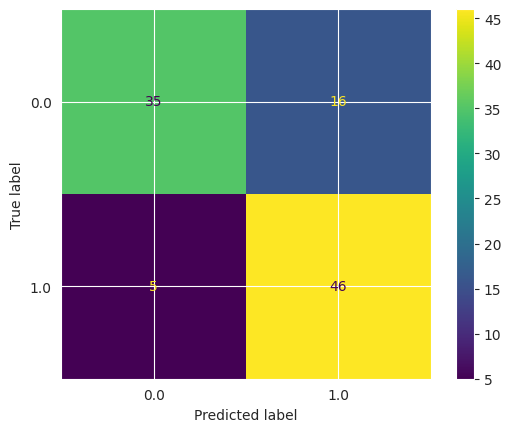

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None)

Si quisieramos aplicar el modelo a nuevos datos, tendríamos que preprocesarlo del mismo modo que a los datos de entrenamiento y deberíamos transformarlo con el TFIDFVectorizar anteriormente entrenado. Despues de eso ya se podría incorporar sin problemas al `model.predict(Xnew)`

#### Importancia de características

In [69]:
# Obtener la importancia de las variables del modelo
importance = model.coef_[0]

In [70]:
# Primero, emparejamos los nombres de las características con su importancia
features_importances = list(zip(X_columns, importance))

# Luego, ordenamos las características por importancia en orden descendente
features_importances_sorted = sorted(features_importances, key=lambda x: x[1], reverse=True)

# Desempaquetamos las listas ordenadas
X_columns_sorted, importance_sorted = zip(*features_importances_sorted)



Feature: 0, Name: fuck, Score: 1.61244
Feature: 1, Name: wake, Score: 1.52950
Feature: 2, Name: loud, Score: 1.51696
Feature: 3, Name: much, Score: 1.46710
Feature: 4, Name: much noise, Score: 1.38353
Feature: 5, Name: outside, Score: 1.31088
Feature: 6, Name: house, Score: 1.26978
Feature: 7, Name: window, Score: 1.16027
Feature: 8, Name: fucking, Score: 1.06960
Feature: 9, Name: constant, Score: 1.05028
Feature: 10, Name: url url, Score: -1.03232
Feature: 11, Name: complaint, Score: -1.05313
Feature: 12, Name: white, Score: -1.08486
Feature: 13, Name: noise pollution, Score: -1.08962
Feature: 14, Name: pollution, Score: -1.13294
Feature: 15, Name: bring, Score: -1.14338
Feature: 16, Name: rain, Score: -1.31047
Feature: 17, Name: num_URLS, Score: -1.61193
Feature: 18, Name: love, Score: -1.90010
Feature: 19, Name: url, Score: -6.66525


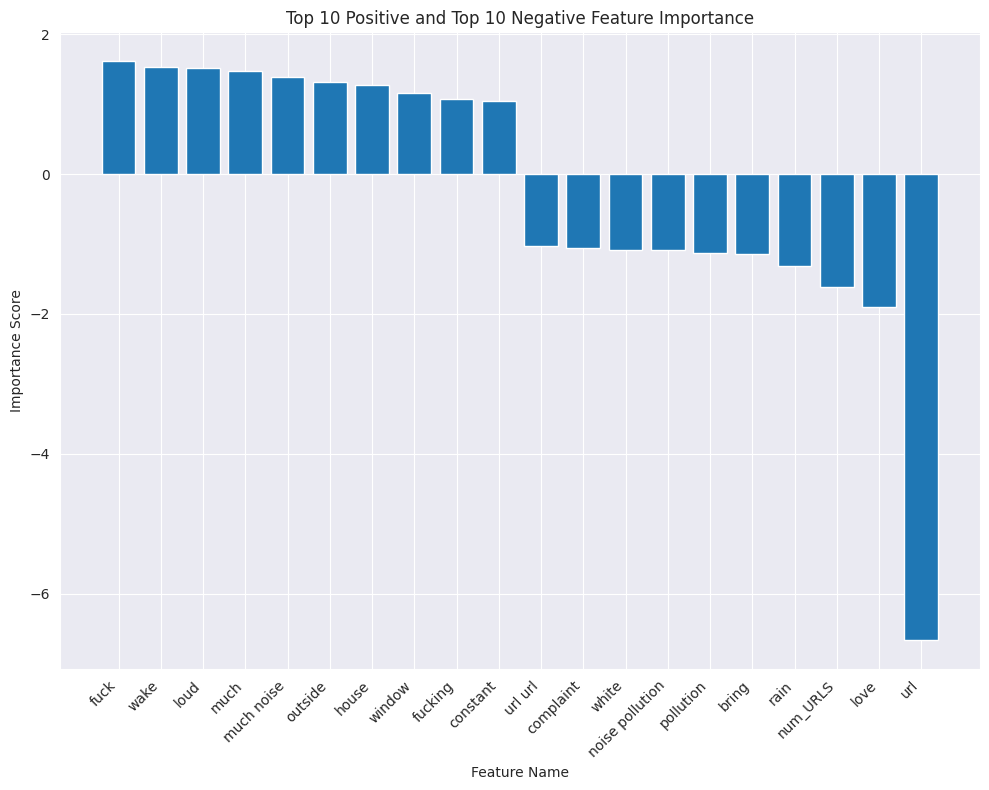

In [71]:

# Seleccionamos solo las 10 más positivas y las 10 más negativas
top_features = X_columns_sorted[:10] + X_columns_sorted[-10:]
top_importance = importance_sorted[:10] + importance_sorted[-10:]

# Mostrar el número de la característica, con su nombre, y su score de importancia
for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
    print('Feature: %0d, Name: %s, Score: %.5f' % (i, feature, importance))

# Crear el plot
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del gráfico según necesites
plt.bar(top_features, top_importance)  # Usar nombres de características ordenadas en el eje x

# Mejorar el gráfico
plt.xticks(rotation=45, ha="right")  # Rota los nombres en el eje x para mejor lectura
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Top 10 Positive and Top 10 Negative Feature Importance')
plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) encaje en el área de la figura.

plt.show()

# Entrenamiento con modelos de lenguaje:


Hasta ahora, hemos construido un clasificador de texto utilizando una técnica clásica de ingeniería de características **TF-IDF** . Este enfoque transforma los textos en vectores numéricos que representan la importancia de cada palabra en el contexto de los documentos, permitiendo aplicar algoritmos de machine learning tradicionales.

Sin embargo, este enfoque tiene limitaciones como que no capta el **significado contextual** de las palabras, es decir que trata cada palabra como entidades independiantes que aparecen o no en un documento.


Ahora daremos un paso adelante utilizando modelos de lenguaje preentrenados, como los basados en la **arquitectura Transformer**.

Cuando se entrena un modelo de lenguaje utilizando una arquitectura de tipo Transformers se utilizan grandes cantidades de textos para que la red neuronal aprenda patrones, relaciones y estructuras de un idioma. Como hemos visto, el resultado de este proceso se conoce como *modelo pre-entrenado*, que esencialmente es una red neuronal que ha capturado el concimiento general del idioma, permitiendo predecir palabras con eficacia, pero sin capacidades de llevar a cabo tareas específicas como la clasificación de textos.

El poder de los modelos pre-entrenados radica en su capacidad para ser ajustados o *afinados* y resolver una tarea específica como traducción automática, resumen de textos, extracción de información o **clasificación de textos**. Este proceso de ajuste se conoce como *fine-tuning*, y cuando se aplica se aprovecha el conocimiento adquirido por el modelo de lenguaje en el pre-entrenamiento para resolver el problema en cuestión.

Al llevar a cabo el ajuste de un modelo pre-entrenado para resolver un problema de clasificación se incorpora una **classification head** que utiliza las representaciones vectoriales generadas por el modelo de lenguaje para ajustar una red neuronal que permita crear predicciones específicas de las categorías que queremos predecir asociadas al texto.

Cuando se utiliza la librería *Transformers* esta capa de clasificación es una red neuronal simple, pero podría utilizarse cualquier otra estructura como un regresor logístico.


## Proceso resumido

Cuando usamos un modelo como **BERT** para tareas de clasificación, el flujo básico es el siguiente:

1. **Tokenizasción**: Primero, el texto se transforma en tokens mediante el tokenizador con el que fue entrenado el modelo de lenguaje. En este proceso se añaden los tokens especiales `[CLS]` y `[SEP]`


2. **Paso por el modelo de lenguaje**: El modelo de lenguaje toma como entrada los tokens y devuelve vectores contextuales (embeddings) para cada uno. El embedding asociado al token `[CLS]` captura una especie de "resumen contextualizado" de todo el texto.

3. **Clasification head**: Este vector `[CLS]` se pasa por una o varias capas lineales (una "classification head"), que aprenden a mapear esa representación a nuestras clases (por ejemplo, "positivo" o "negativo", en el caso de la imagen.).


4. **Entrenamiento (Fine-tuning)**: Durante el fine-tuning, se ajustan tanto los pesos del modelo de lenguaje como los de la clasificación, utilizando nuestros propios datos etiquetados.





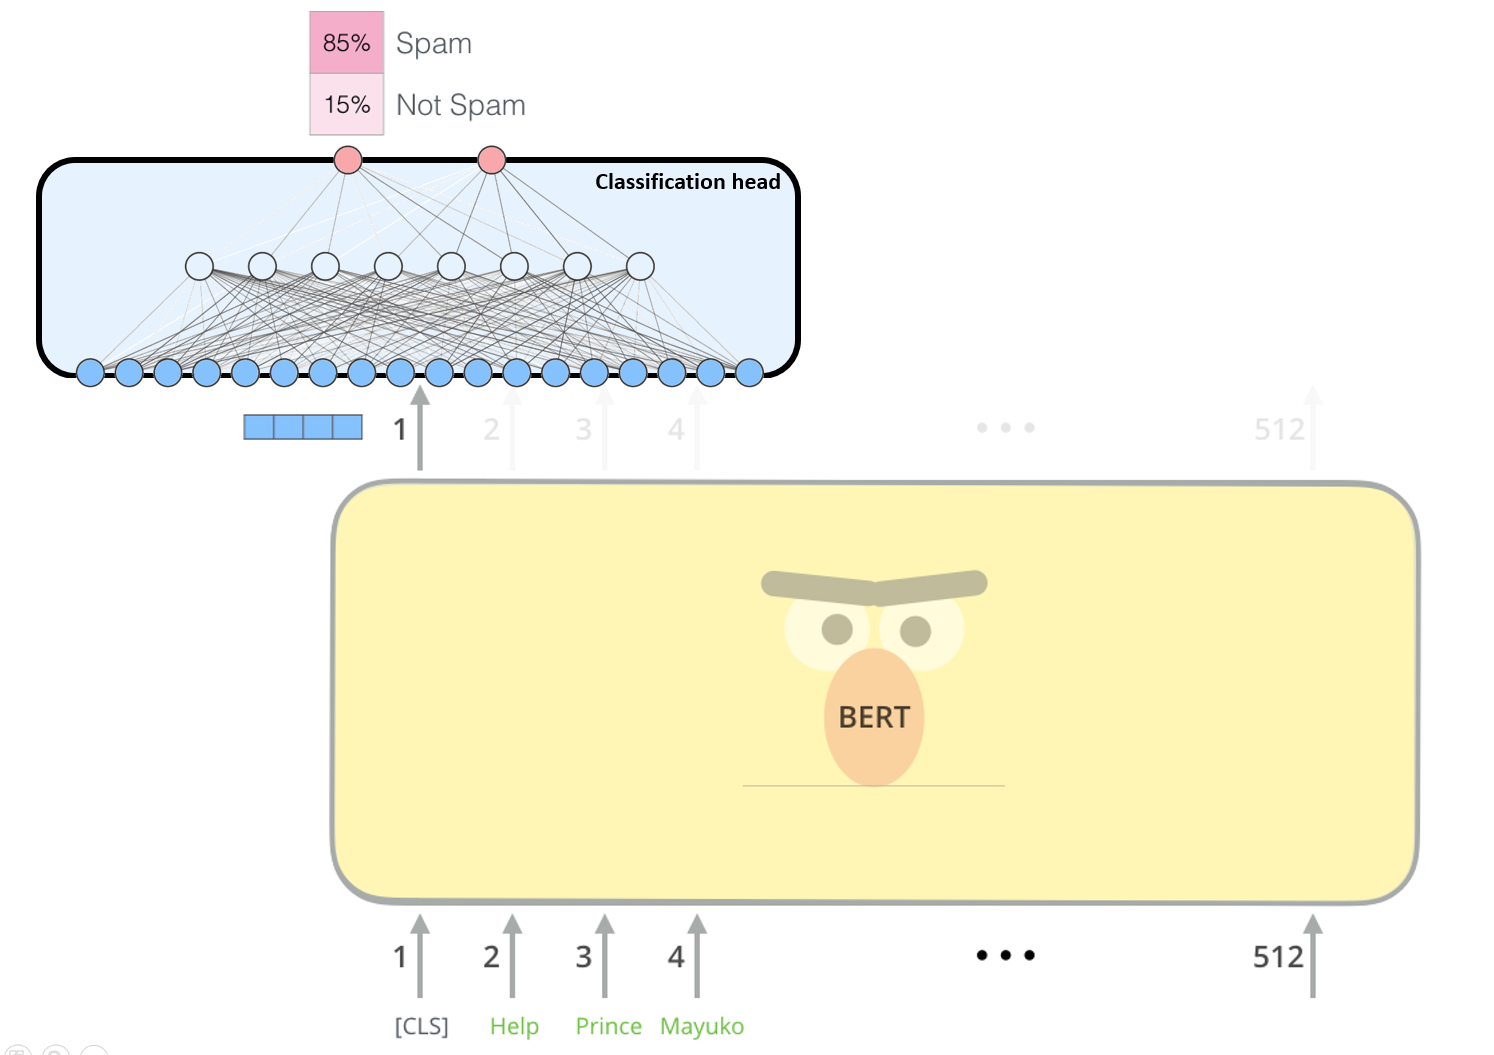

## Descarga y preparación de datos

En primer lugar, vamos a convertir el Dataframe utilizado previamente a un objeto de la librería Huggingface.
Adicionalmente, renombramos la columna `molestia` del objeto Dataset creado a `labels`, que es el nombre estándar que esperan muchos modelos de clasificación en Hugging Face.





In [72]:
from datasets import Dataset, DatasetDict, ClassLabel
dataset_hf = Dataset.from_pandas(dataset).rename_column("molestia", "labels")  # from_pandas(dataset).rename_column("molestia", "labels")

Indicamos que la columna `labels` representa una variable categórica con 2 clases (por ejemplo: 0 = "no queja de ruido", 1 = "queja de ruido"). Esto permite que Hugging Face maneje las etiquetas correctamente durante el entrenamiento y la evaluación.

In [73]:
dataset_hf = dataset_hf.cast_column("labels", ClassLabel(num_classes=2))

Casting the dataset:   0%|          | 0/1019 [00:00<?, ? examples/s]

In [74]:
dataset_hf

Dataset({
    features: ['tweet_text', 'labels', 'char_len', 'normalized', 'preprocessed_text', 'num_mention', 'num_URLS', 'num_NUM', 'num_ADJ', '__index_level_0__'],
    num_rows: 1019
})

Dividimos el dataset en train, development y test.

Al entrenar un modelo de lenguaje (o cualquier modelo de machine learning), no podemos evaluar su rendimiento usando los mismos datos con los que lo entrenamos. Por eso, dividimos los datos en tres conjuntos con propósitos distintos:

- **Train**: Este conjunto se utiliza para ajustar los pesos del modelo. Aquí es donde el modelo "aprende" a hacer la tarea, minimizando el error en estos ejemplos a través del proceso de entrenamiento.

- **Development**: Este conjunto, a veces llamado "dev", se usa para evaluar el rendimiento del modelo durante el entrenamiento, pero sin formar parte del entrenamiento directo. Sirve para elegirt los mejores hiperparámetros, decidir cuando deter el entrenamiento y comprender si el modelo está generalizando bien.

- **Test**: Este conjunto se guarda hasta el final y se usa una sola vez, después de entrenar y ajustar el modelo.




In [75]:
# Dividir el conjunto de datos en train y test (80% train, 20% test)
train_testvalid = dataset_hf.train_test_split(test_size=0.2, seed=43, stratify_by_column="labels")

# Dividir el conjunto de test en dev y test (50% dev, 50% test)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=43, stratify_by_column="labels")


In [76]:
# Crear un DatasetDict con train, dev y test
split_datasets = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'dev': test_valid['train']
})

# Acceder a los conjuntos de datos divididos
train_dataset = split_datasets['train']
dev_dataset = split_datasets['dev']
test_dataset = split_datasets['test']

### Tokenización

Antes de poder ajustar un modelo de lenguaje, necesitamos convertir nuestro texto en un formato que el modelo pueda entender. Esto se hace mediante el uso del tokenizador del modelo de lenguaje



In [77]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification
)

En primer lugar, debemos decidir a que modelo de lenguaje queremos hacer el *fine-tuning*. En este caso, como estamos trabajando con textos en inglés utilizaremos el modelo **distilbert**, un modelo de lenguaje ligero ideal para entornos de enseñanza.

Cargamos el tokenizador con una clase de la librería Transformers `AutoTokenizer()`, que cargará el tokenizador sin tener que preocuparnos de otros parámetros relativos a su arquitectura.

In [78]:
model_name = 'distilbert/distilbert-base-uncased' #  'distilbert/distilbert-base-uncased'

In [79]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Aquí vemos cómo el tokenizer divide el texto en subpalabras. Por ejemplo, palabras como "zebras" pueden dividirse en tokens como "zebra" y "##s" si no están en el vocabulario completo del modelo.  Este enfoque permite al modelo manejar cualquier palabra, incluso si no la ha visto durante su preentrenamiento, además de reducir el tamaño del vocabulario.

In [80]:
texto = "Cats and zebras love to nap in sunny spots"
texto_tokens = tokenizer(texto).tokens()
texto_tokens

['[CLS]',
 'cats',
 'and',
 'zebra',
 '##s',
 'love',
 'to',
 'nap',
 'in',
 'sunny',
 'spots',
 '[SEP]']

A continuación, definimos una función de preprocesamiento que tokenice nuestros subsets de datos. Para ello seleccionamos un *padding* con valor **max_length**, que asegura que todos los textos tengan la misma longitud en cada batch. Además, el valor `truncation=True` corta los textos que no entren en la ventana de contexto del modelo.

In [81]:
def preprocess_function(examples):
    # Tokenizar el texto
    return tokenizer(examples['tweet_text'], padding="max_length", truncation=True)

In [82]:
train_dataset = train_dataset.map(preprocess_function, batched=True) # preprocess_function
dev_dataset = dev_dataset.map(preprocess_function, batched=True) # preprocess_function
test_dataset = test_dataset.map(preprocess_function, batched=True) # preprocess_function

Map:   0%|          | 0/815 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

### Fine-tuning

Una vez que tenemos nuestros datos tokenizados, es hora de crear el modelo, configurar los parámetros de entrenamiento y definir cómo queremos evaluar su rendimiento.



En primer lugar, cargamos el modelo pre-entrenado con una cabeza de clasificaicón que ajustaremos posteriormente utilizando la clase `AutoModelForSequenceClassification()`. Dentro de la clase indicamos que hay 2 categorías, y proporcionamos un mapeo entre los IDs numéricos (0, 1) y las etiquetas semánticas ("NO_MOLESTIA", "MOLESTIA"), lo que facilita luego la interpretación de resultados.



In [83]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NO_MOLESTIA", 1: "MOLESTIA"}
label2id = {"NO_MOLESTIA": 0, "MOLESTIA": 1}

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Configuración del Entrenamiento del Modelo



A continuación, se detallan los principales parámetros utilizados para entrenar el modelo:

- **learning_rate**: Bajo. Ideal para datasets pequeños y procesos de *fine-tuning*, ya que permite una adaptación más precisa sin grandes saltos en los pesos.

- **eval_strategy="steps"**: Se evalúa el modelo cada 50 pasos de entrenamiento, en lugar de al final de cada época. Esto permite una supervisión más frecuente del rendimiento en validación.

- **load_best_model_at_end=True**: Al finalizar el entrenamiento, se carga automáticamente el modelo que haya obtenido la mejor puntuación en validación.

- **weight_decay**: Se utiliza como técnica de regularización para evitar el sobreajuste (*overfitting*) penalizando grandes valores en los pesos del modelo.

- **logging_steps**: Indica cada cuántos pasos se deben registrar las métricas de entrenamiento. Permite un monitoreo detallado del progreso.

- **output_dir**: Carpeta donde se guardan todos los resultados del entrenamiento, incluidos los checkpoints y el modelo final.


In [84]:
training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.1,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none"
)


In [ ]:
# Para que hubiera repetibilidad en el entrenamiento
# habría que fijar una seed en trainingarguments con seed=52

#### Definición de métricas de evaluación


Definiremos dos métricas de evaluación que podremos explorar mientras se entrena el modelo: accuracy y f1-score.

In [85]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)["f1"]

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }


#### Entrenamiento


Ya tenemos el modelo, los datos, los argumentos de entrenamiento y la función de evaluación. Ahora usamos la clase `Trainer`, que se encarga de orquestar el entrenamiento, evaluación y guardado del modelo.


- **model**: Nuestro modelo preentrenado, en este caso DistilBERT, al que se le ha añadido una cabeza de clasificación para tareas de *text classification*.

- **args**: Argumentos de entrenamiento definidos previamente mediante `TrainingArguments`. Incluyen parámetros como la tasa de aprendizaje, evaluación por pasos, número de épocas, entre otros.

- **train_dataset**: Conjunto de datos utilizado para entrenar el modelo.

- **eval_dataset**: Conjunto de validación que se utiliza para evaluar el rendimiento del modelo durante el proceso de entrenamiento.

- **tokenizer**: El tokenizador asociado al modelo. Se incluye para que el modelo pueda guardarse junto con la información necesaria para preprocesar nuevos textos posteriormente.

- **compute_metrics**: Función personalizada que define cómo se calculan las métricas de evaluación, como *accuracy*, *precision*, *recall* o *F1-score*.

In [86]:
trainer = Trainer(
    model=model,  # model
    args=training_args,  # training_args
    train_dataset=train_dataset,  # train_dataset
    eval_dataset=dev_dataset,  # dev_dataset
    tokenizer=tokenizer ,# tokenizer
    compute_metrics=compute_metrics, # compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2) # Podriamoshacer une arly stop
)

In [87]:
trainer.train() #train()

Step,Training Loss,Validation Loss,Accuracy,F1 Score
50,0.476500,0.506831,0.794118,0.787879
100,0.444800,0.466472,0.803922,0.807692
150,0.310700,0.452470,0.794118,0.787879
200,0.239700,0.344829,0.852941,0.859813
250,0.182600,0.330967,0.882353,0.884615
300,0.130500,0.356182,0.882353,0.888889
350,0.129600,0.363071,0.882353,0.890909
400,0.084100,0.363304,0.882353,0.888889


TrainOutput(global_step=408, training_loss=0.24575411002425587, metrics={'train_runtime': 169.0348, 'train_samples_per_second': 19.286, 'train_steps_per_second': 2.414, 'total_flos': 431843719618560.0, 'train_loss': 0.24575411002425587, 'epoch': 4.0})

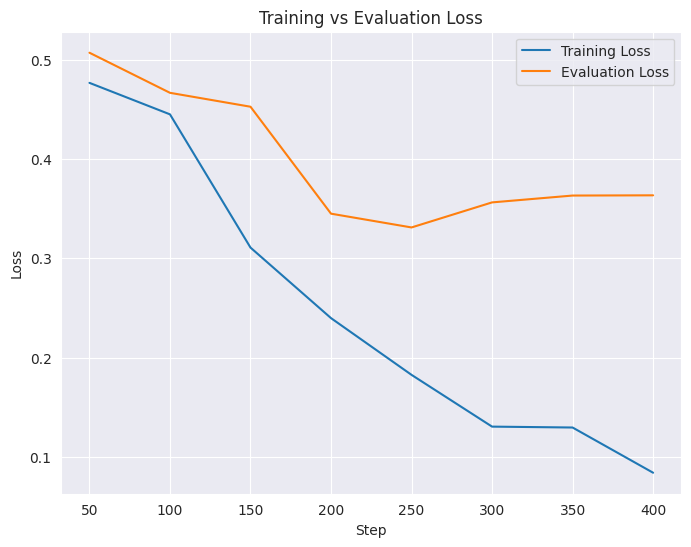

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraemos los logs de entrenamiento
history = pd.DataFrame(trainer.state.log_history)

# A veces los logs pueden tener pasos donde no se evalúa. Filtramos filas con 'loss' y 'eval_loss'
train_loss = history[history['loss'].notna()][['step', 'loss']]
eval_loss = history[history['eval_loss'].notna()][['step', 'eval_loss']]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


Una vez entrenado el modelo, podemos guardarlo en local:

In [ ]:
trainer.___________  # save_model("output_model_save")

También podríamos subirlo al Hub de HuggingFace con el método `.push_to_hub()`



```
trainer.push_to_hub(commit_message="Training completed!")
```



### Evaluación

Una vez entrenado el modelo, llevaremos a cabo su evaluación.

El objeto `Trainer()` tiene un método `.evaluate()` que permite introducir un conjunto de datos de evaluación y obtener las métricas accuracy y f1 definidas previamente.

In [91]:
trainer.evaluate(test_dataset) # evaluate(test_dataset)

{'eval_loss': 0.4031694531440735,
 'eval_accuracy': 0.8529411764705882,
 'eval_f1_score': 0.8514851485148515,
 'eval_runtime': 1.6205,
 'eval_samples_per_second': 62.942,
 'eval_steps_per_second': 8.022,
 'epoch': 4.0}

También vamos a hacer un classification report para ver los scores relativo a cada categoría. Para eso, predeciremos las etiquetas sobre el test set con el método `.predict()`. Y obtendremos la etiqueta de cada predicción.

In [92]:
predictions = trainer.predict(test_dataset)  # predict(test_dataset)

In [96]:
predictions[0]

array([[ 0.98221856, -0.8754151 ],
       [ 1.476692  , -1.5870799 ],
       [ 2.6942961 , -2.6432729 ],
       [-2.5515387 ,  2.2721112 ],
       [-1.5421172 ,  1.5038357 ],
       [ 2.700086  , -2.5985787 ],
       [-1.9494313 ,  1.7952436 ],
       [-2.2942836 ,  2.002329  ],
       [ 2.682468  , -2.630256  ],
       [ 1.0021162 , -1.0181048 ],
       [-1.0968292 ,  1.2071507 ],
       [-2.2268727 ,  2.1690671 ],
       [ 2.7131023 , -2.644928  ],
       [-2.327458  ,  2.276134  ],
       [-0.89089686,  0.75965226],
       [ 2.7637737 , -2.626977  ],
       [-1.4439552 ,  1.2809231 ],
       [ 2.6587784 , -2.5639021 ],
       [-1.3206745 ,  1.2798796 ],
       [ 2.7110126 , -2.6090863 ],
       [-2.3335092 ,  2.2882    ],
       [ 0.42059594, -0.52789617],
       [ 2.2252874 , -2.1626244 ],
       [-1.9738452 ,  1.813671  ],
       [ 2.6904633 , -2.691282  ],
       [-2.3845208 ,  2.1864748 ],
       [ 2.7125516 , -2.6408107 ],
       [-2.238326  ,  2.1393847 ],
       [-2.3986673 ,

In [94]:
y_pred = predictions.predictions.argmax(axis=1)
y_true = [x["labels"] for x in test_dataset]

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[44  7]
 [ 8 43]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        51
           1       0.86      0.84      0.85        51

    accuracy                           0.85       102
   macro avg       0.85      0.85      0.85       102
weighted avg       0.85      0.85      0.85       102




```
  [[35 16]
  [ 6 45]]
```


```

              precision    recall  f1-score   support

         0.0       0.85      0.69      0.76        51
         1.0       0.74      0.88      0.80        51

    accuracy                           0.78       102
   macro avg       0.80      0.78      0.78       102
weighted avg       0.80      0.78      0.78       102

```

### Reutilización

Una de las mayores fortalezas del ecosistema Hugging Face es que **todo el flujo está unificado y estandarizado**: entrenamos un modelo, lo guardamos, y luego podemos volver a cargarlo en una sola línea con la clase `pipeline()`.

Esto nos permite reutilizar el modelo sin tener que preocuparnos en el procesado del texto, pudiendo hacer inferencias de forma rápida y construir prototipos rápidos.



In [ ]:
from transformers import pipeline

# Cargar el modelo y el tokenizer directamente desde el directorio guardado
modelo_clasificacion = pipeline("text-classification", model="/content/output_model_save", tokenizer=model_name)


Device set to use cuda:0


In [ ]:
texto_nuevo_noqueja = "I feel so lucky that today is about the quietest its ever been here. Fewer copters, no construction noise. Ahhhhhhhhh #selfcare https://t.co/7Ka4M6wFQv"
texto_nuevo_queja = "OMG!! 😩 I can't stand it when the neighbor starts mowing the lawn at 6 AM on Sundays 😤🌾🔊"

print(modelo_clasificacion(texto_nuevo_noqueja))
print(modelo_clasificacion(texto_nuevo_queja))